# Finetuning tests with GPT-base on EHRSHOT

In [82]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from typing import List, Dict, Tuple, Optional
from tqdm import tqdm
import seaborn as sns
tqdm.pandas()
sns.set_context("paper")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Make Plots

In [83]:
task: str = 'guo_los'
k: int = -1
head: str = 'finetune_layers=2'
model: str = 'gpt2-base-512--clmbr_train-tokens-total_nonPAD-true_val=600000896-ckpt_val=600000000-persist_chunk:last_embed:last'

In [95]:
# Read all .json's in folder
path_to_folder: str = f'/share/pi/nigam/mwornow/ehrshot-benchmark/EHRSHOT_ASSETS/finetunes/{model}/'
df_losses = []
df_metrics = []
for head in tqdm(os.listdir(path_to_folder)):
    # /share/pi/nigam/mwornow/ehrshot-benchmark/EHRSHOT_ASSETS/finetunes/{model}/{head}
    if not os.path.isdir(os.path.join(path_to_folder, head)):
        continue
    for task in os.listdir(os.path.join(path_to_folder, head)):
        if not os.path.isdir(os.path.join(path_to_folder, head, task)):
            continue
        # /share/pi/nigam/mwornow/ehrshot-benchmark/EHRSHOT_ASSETS/finetunes/{model}/{head}/{task}/
        for k in os.listdir(os.path.join(path_to_folder, head, task)):
            # /share/pi/nigam/mwornow/ehrshot-benchmark/EHRSHOT_ASSETS/finetunes/{model}/{head}/{task}/k={k}/
            if not os.path.isdir(os.path.join(path_to_folder, head, task, k)):
                continue
            path_to_sub_folder: str = os.path.join(path_to_folder, head, task, k)
            k: int = int(k.split('=')[1])
            for file in tqdm(os.listdir(path_to_sub_folder)):
                if file.endswith(".json"):
                    with open(os.path.join(path_to_sub_folder, file), 'r') as f:
                        data = json.load(f)
                        df_losses+= [{
                            'lr' : data['lr'],
                            'k' : data['k'],
                            'model' : data['model'],
                            'head' : data['head'],
                            'sub_task' : data['sub_task'],
                            'loss' : loss,
                            'step' : idx,
                        } for idx, loss in enumerate(data['losses']) ]
                        df_metrics += [{
                                'model' : data['model'],
                                'head' : data['head'],
                                'sub_task' : data['sub_task'],
                                'k' : data['k'],
                                'lr' : data['lr'],
                                'metric' : metric,
                                'value' : val,
                                'epoch' : epoch,
                                'split' : split,
                            } 
                            for epoch, vals in enumerate(data['metrics']) 
                            for metric, metric_vals in vals.items() 
                            for split, val in metric_vals.items()
                        ]
df_metrics = pd.DataFrame(df_metrics)
df_losses = pd.DataFrame(df_losses)
df_losses['lr'] = df_losses['lr'].astype('category')
df_metrics['lr'] = df_metrics['lr'].astype('category')
df_metrics['uuid'] = df_metrics.apply(lambda x: f"{x['model']}_{x['head']}_{x['sub_task']}_{x['lr']}_{x['k']}_{x['epoch']}_{x['metric']}", axis=1)

100%|██████████| 9/9 [00:00<00:00, 588.20it/s]


100%|██████████| 4/4 [00:00<00:00, 22.17it/s]


In [142]:
def make_plots(df_losses: pd.DataFrame, df_metrics: pd.DataFrame, sub_task: str, model: str, split: str = 'val'):
    # Create a 3 horizontal grids of line plots for this task
    # In the first grid (1x5), have a line plot for each of the 5 heads showing validation AUROC for different learning rates.
    # In the third grid (1x5), have a line plot for each of the 5 heads showing validation AUROC for different learning rates.
    # In the second grid (1x8), have a line plot for each of the 8 learning rates showing validation AUROC for different heads
    # Filter data for this task and head
    import warnings
    warnings.filterwarnings('ignore')
    df_l = df_losses[(df_losses['sub_task'] == sub_task) & (df_losses['model'] == model)].copy()
    df_m = df_metrics[(df_metrics['metric'] == 'auroc') & (df_metrics['sub_task'] == sub_task) & (df_metrics['model'] == model) & (df_metrics['split'] == split)].copy()
    # First grid (1x5)
    fig1, ax1 = plt.subplots(1, max(2, df_m['head'].nunique()), figsize=(20, 4))
    fig1.suptitle(f'Train Loss | task={sub_task} | model={model}')
    for i, head in enumerate(df_l['head'].unique()):
        data = df_l[df_l['head'] == head]
        data['ema_loss'] = data.groupby('lr')['loss'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
        sns.lineplot(x='step', y='ema_loss', hue='lr', data=data, ax=ax1[i])
        ax1[i].set_title(f'head={head}')
        ax1[i].set_xlabel('Step')
        ax1[i].set_ylabel('Train Loss')
        ax1[i].set_yscale('log')
    plt.show()
    # Second grid (1x8)
    fig2, ax2 = plt.subplots(1, max(2, df_m['lr'].nunique()), figsize=(32, 4))
    fig2.suptitle(f'AUROC | task={sub_task} | model={model} | split={split}')
    for i, lr in enumerate(df_m['lr'].unique()):
        sns.lineplot(x='epoch', y='value', hue='head', data=df_m[df_m['lr'] == lr], ax=ax2[i])
        ax2[i].set_title(f'lr={lr}')
        ax2[i].set_xlabel('Epoch')
        ax2[i].set_ylabel('AUROC')
    plt.show()
    # Third grid (1x5)
    fig3, ax3 = plt.subplots(1, max(2, df_m['head'].nunique()), figsize=(20, 4))
    fig3.suptitle(f'AUROC | task={sub_task} | model={model} | split={split}')
    for i, head in enumerate(df_m['head'].unique()):
        sns.lineplot(x='epoch', y='value', hue='lr', data=df_m[df_m['head'] == head], ax=ax3[i])
        ax3[i].set_title(f'head={head}')
        ax3[i].set_xlabel('Epoch')
        ax3[i].set_ylabel('AUROC')
    plt.show()
    # For each head, find the highest validation auroc reported across all learning rates, and print both the train AUROC, val AUROC, and test AUROC for that model/head/epoch.
    df = df_metrics[(df_metrics['metric'] == 'auroc') & (df_metrics['sub_task'] == sub_task) & (df_metrics['model'] == model)].copy()
    df['max_auroc'] = df[df['split'] == 'val'].groupby('head')['value'].transform('max')
    df = df[df['value'] == df['max_auroc']]
    df_val = df_metrics[df_metrics['uuid'].isin(df['uuid']) & (df_metrics['split'] == 'val')][['model', 'head', 'epoch', 'lr', 'value',]]
    df_test = df_metrics[df_metrics['uuid'].isin(df['uuid']) & (df_metrics['split'] == 'test')][['model', 'head', 'epoch', 'lr', 'value',]]
    print(f"Best test AUROC for `{task}`\n", df_test[['head', 'value', 'epoch', 'lr']].sort_values('value', ascending=False))
    print(f"Best val AUROC for `{task}`\n", df_val[['head', 'value', 'epoch', 'lr']].sort_values('value', ascending=False))

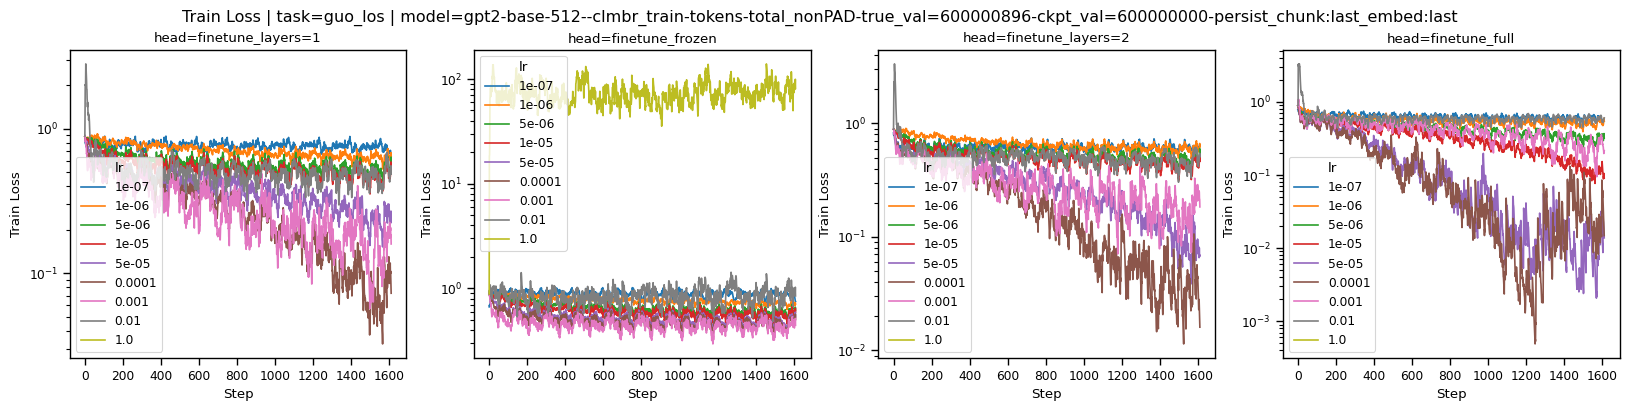

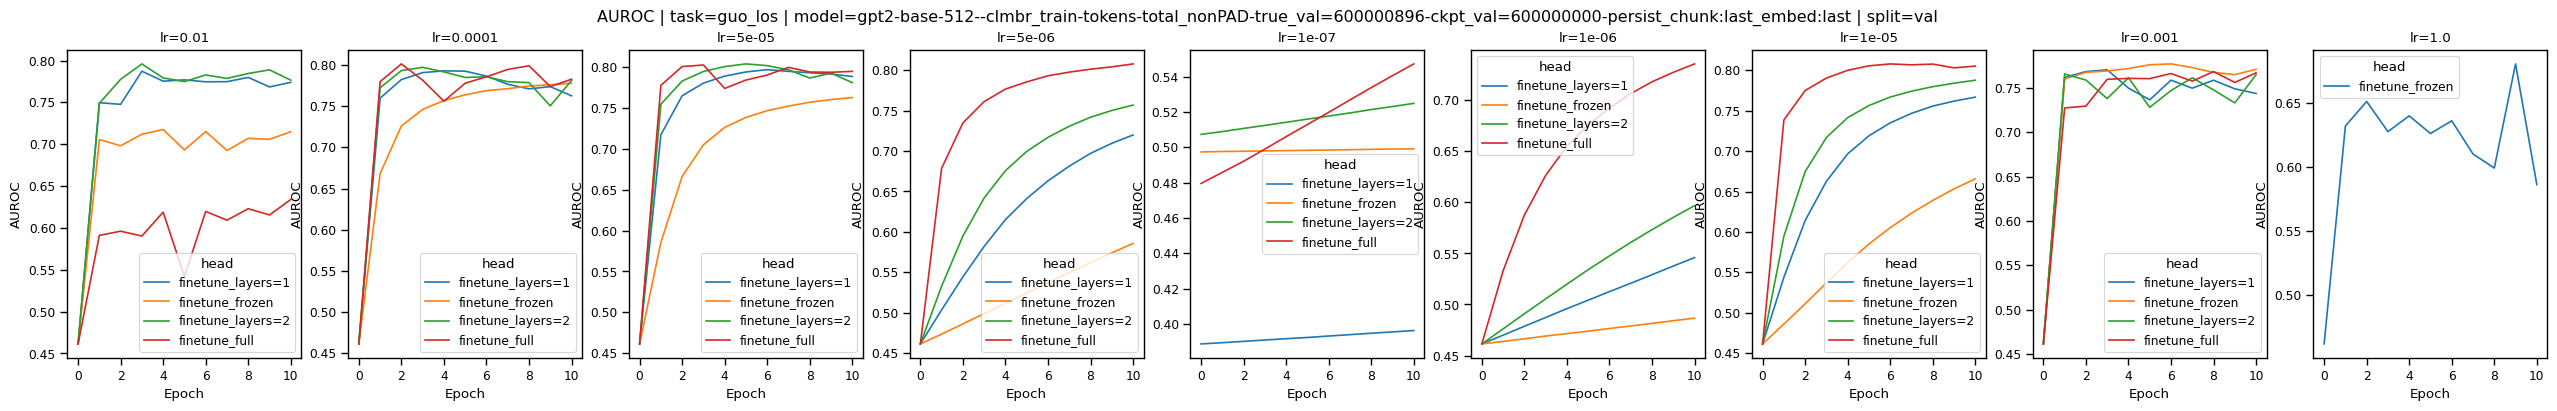

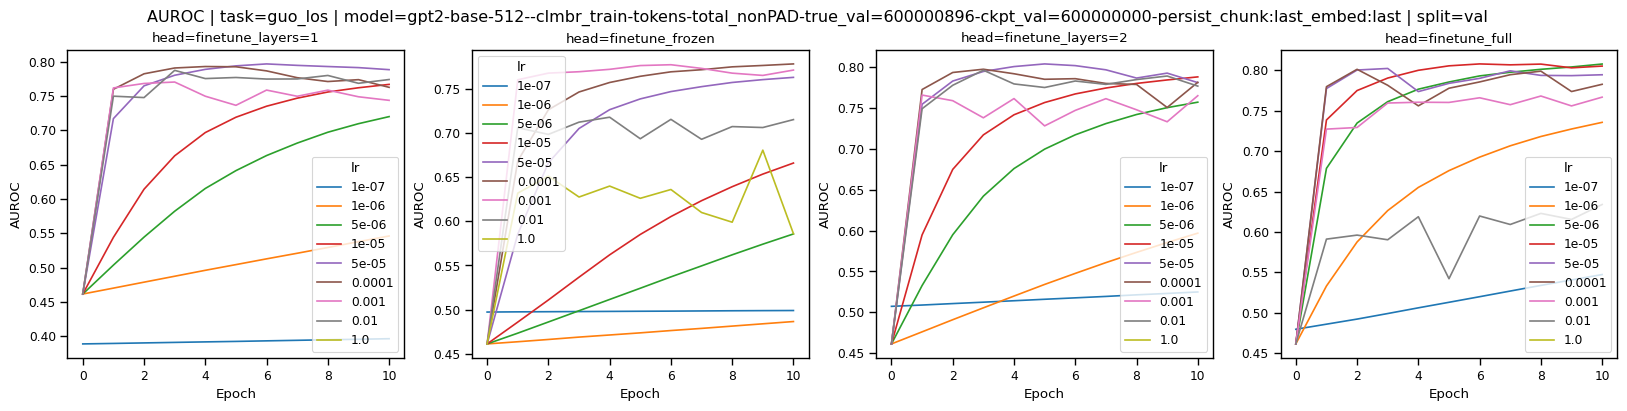

Best test AUROC for `guo_los`
                    head     value  epoch       lr
7454  finetune_layers=2  0.813806      5  0.00005
338   finetune_layers=1  0.812475      6  0.00005
9050      finetune_full  0.800477      6  0.00001
2498    finetune_frozen  0.779797     10  0.00010
Best val AUROC for `guo_los`
                    head     value  epoch       lr
9049      finetune_full  0.807977      6  0.00001
7453  finetune_layers=2  0.803670      5  0.00005
337   finetune_layers=1  0.796688      6  0.00005
2497    finetune_frozen  0.777784     10  0.00010


In [143]:
make_plots(df_losses, df_metrics, 'guo_los', model, 'val')

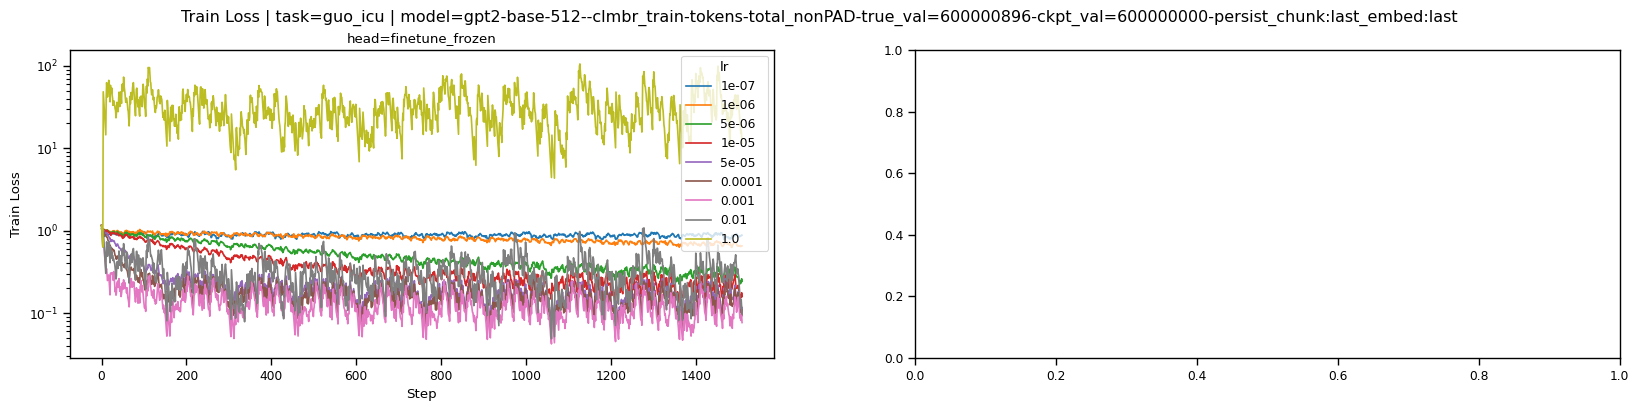

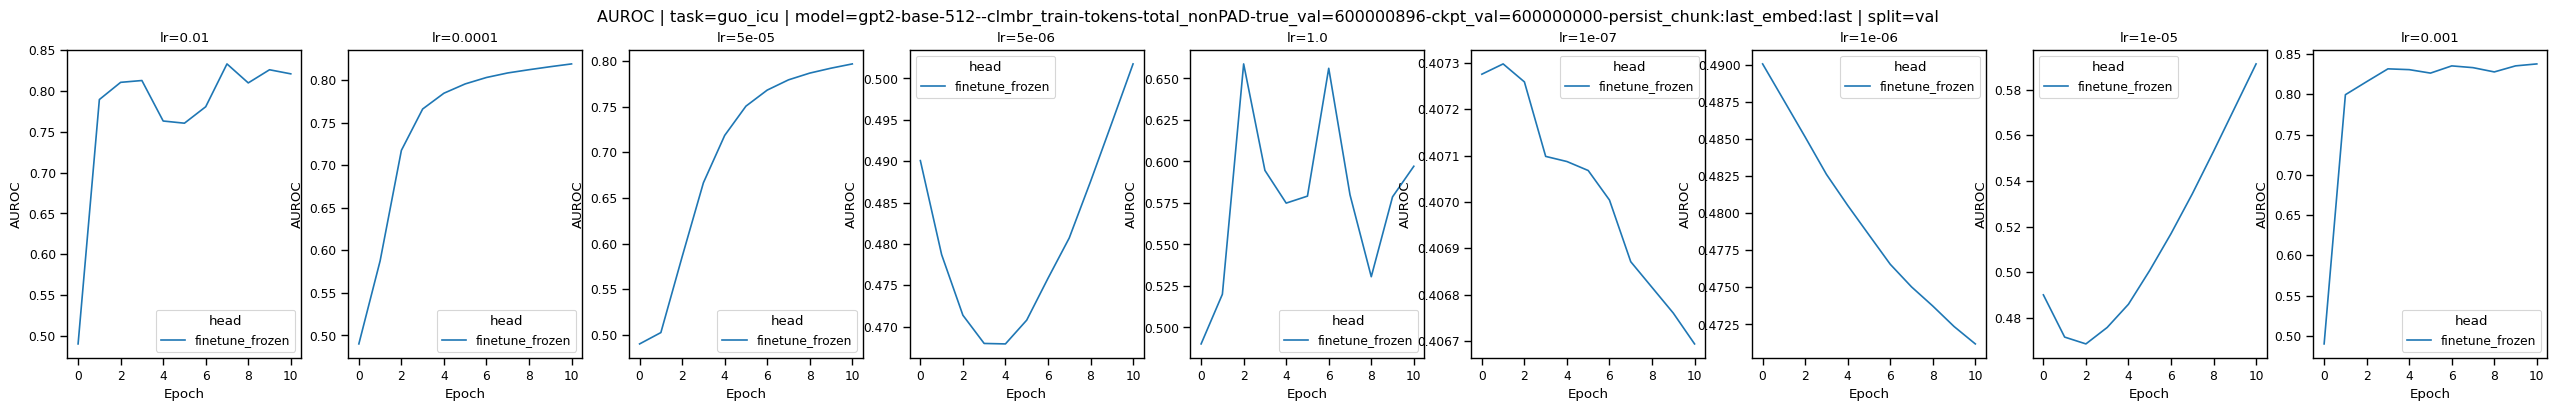

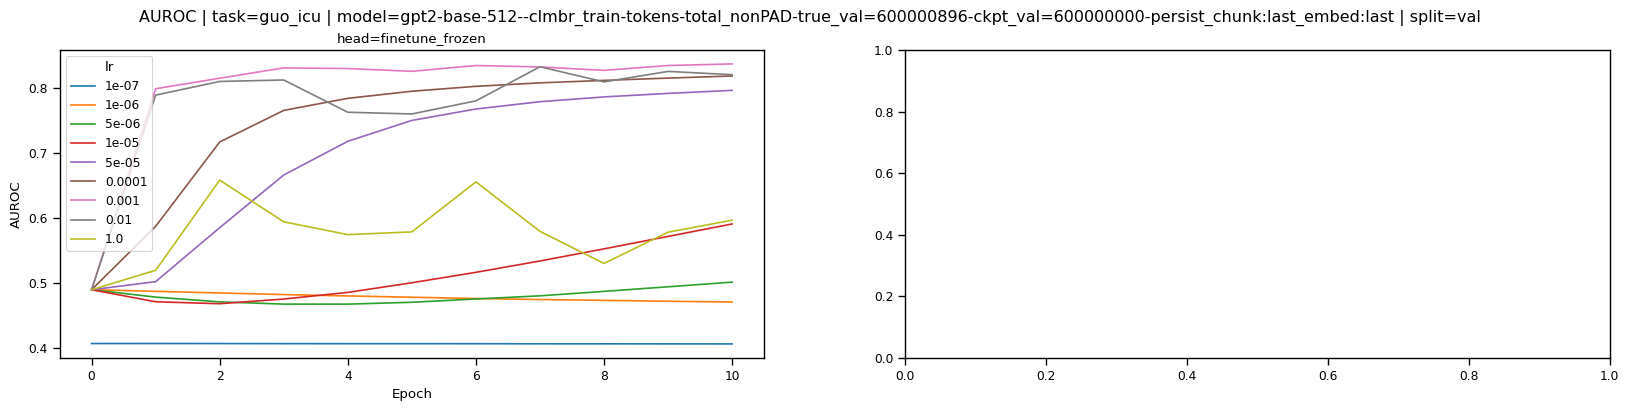

Best test AUROC for `guo_los`
                  head     value  epoch     lr
7118  finetune_frozen  0.821354     10  0.001
Best val AUROC for `guo_los`
                  head     value  epoch     lr
7117  finetune_frozen  0.837616     10  0.001


In [144]:
make_plots(df_losses, df_metrics, 'guo_icu', model, 'val')

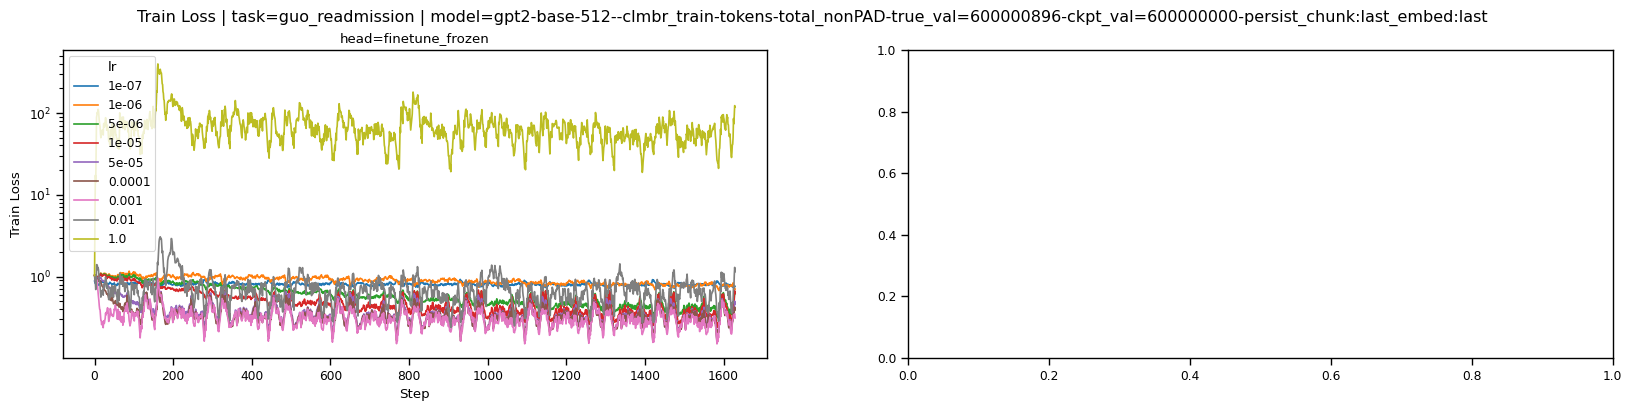

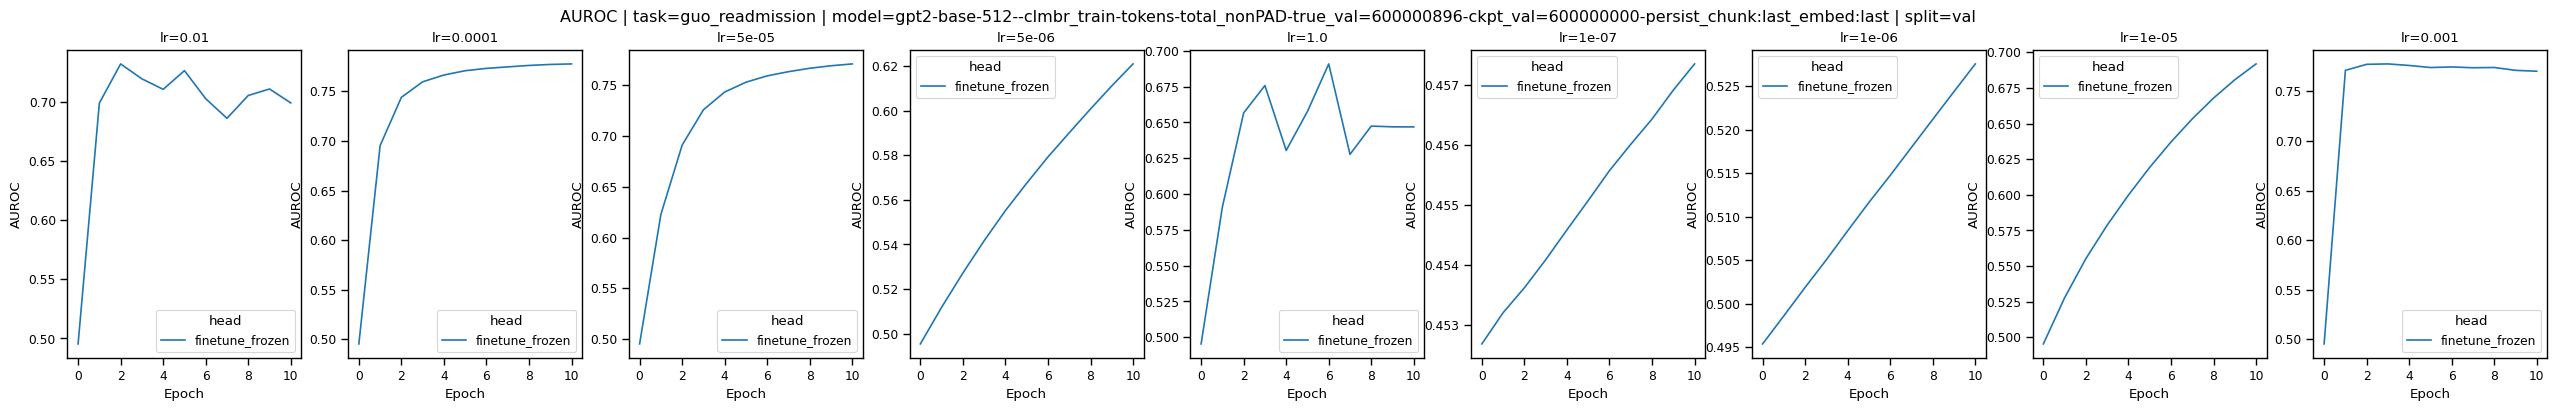

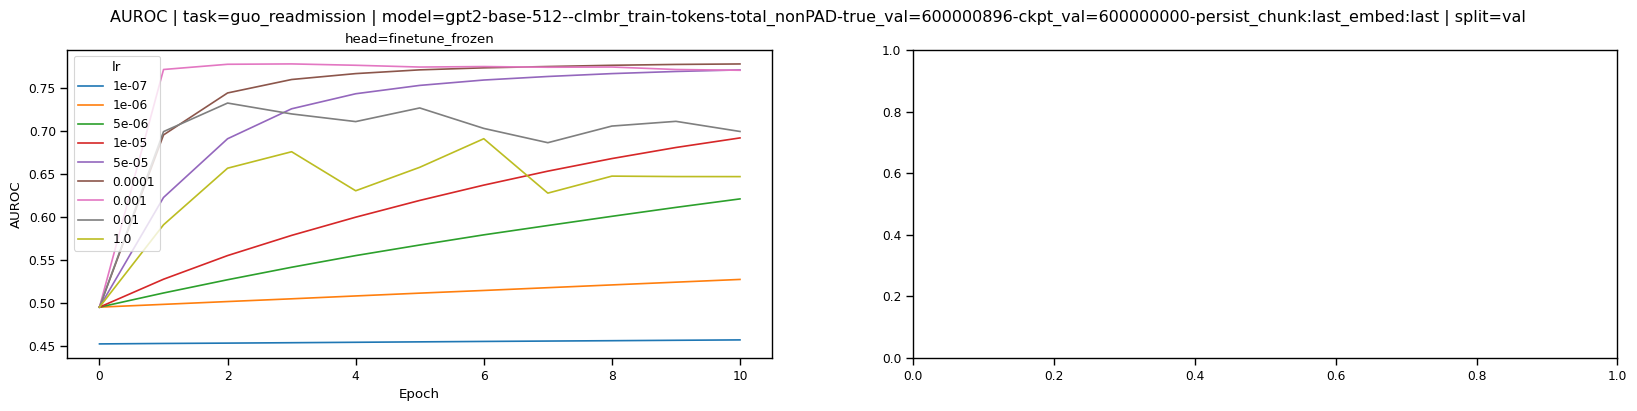

Best test AUROC for `guo_los`
                  head     value  epoch     lr
5846  finetune_frozen  0.793281      3  0.001
Best val AUROC for `guo_los`
                  head     value  epoch     lr
5845  finetune_frozen  0.777727      3  0.001


In [145]:
make_plots(df_losses, df_metrics, 'guo_readmission', model, 'val')

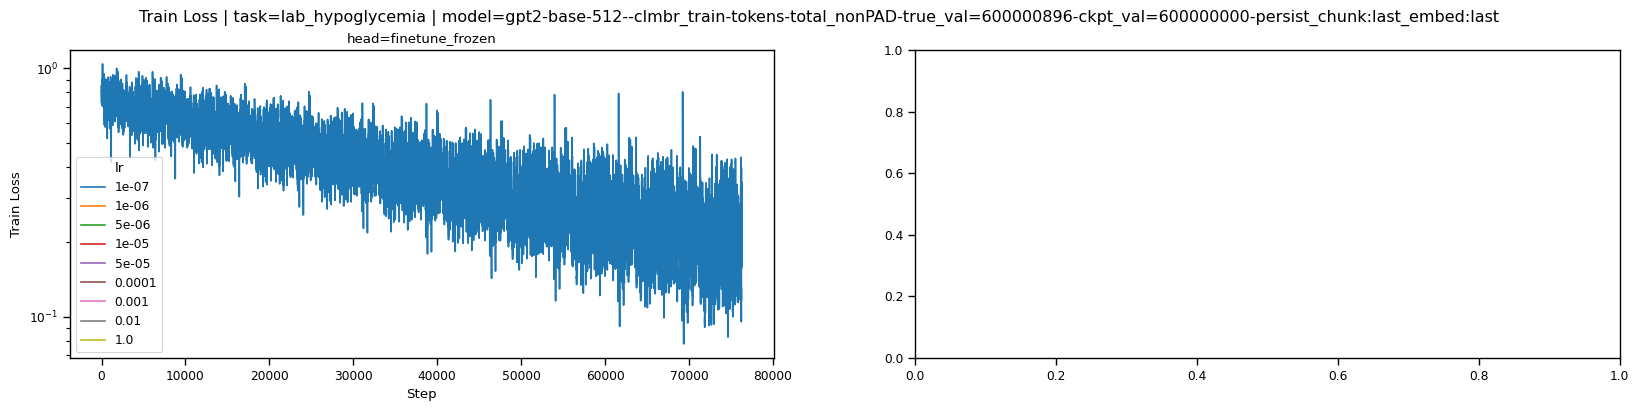

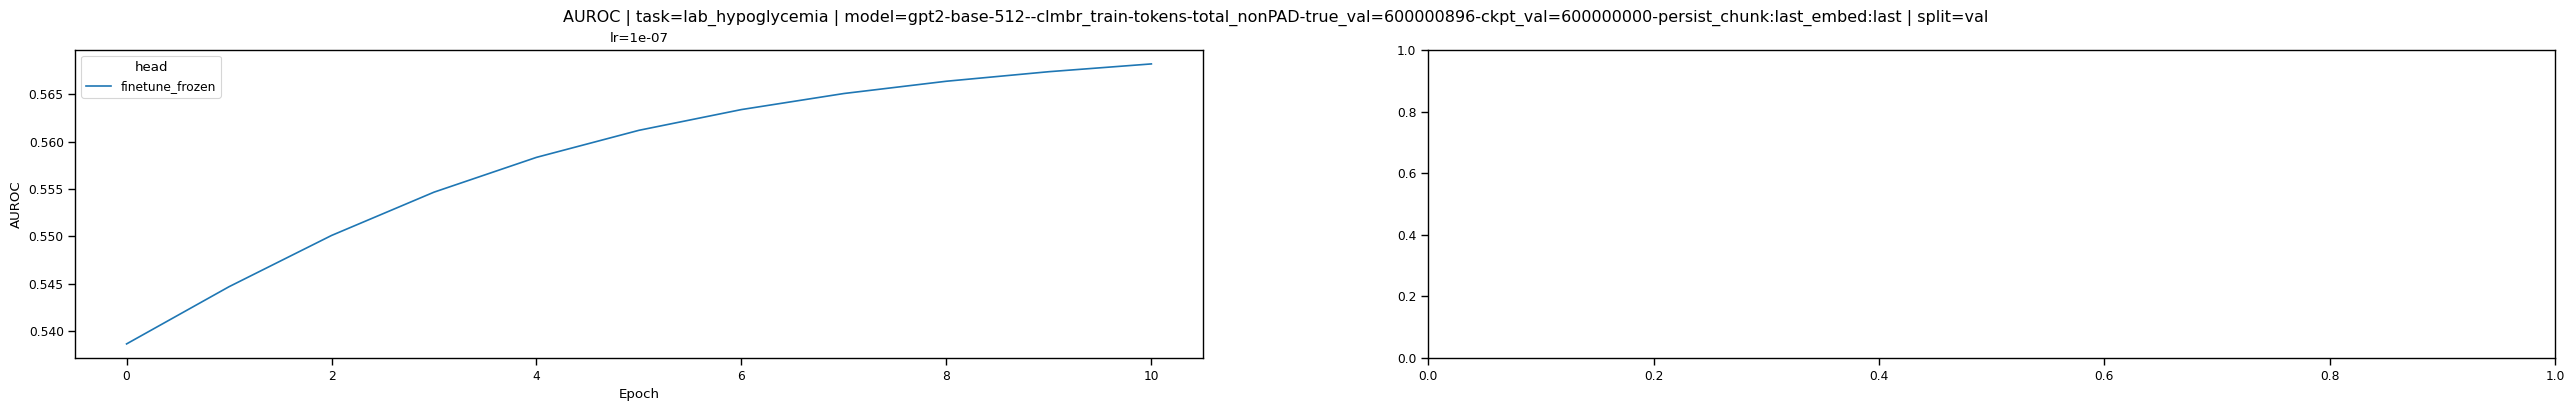

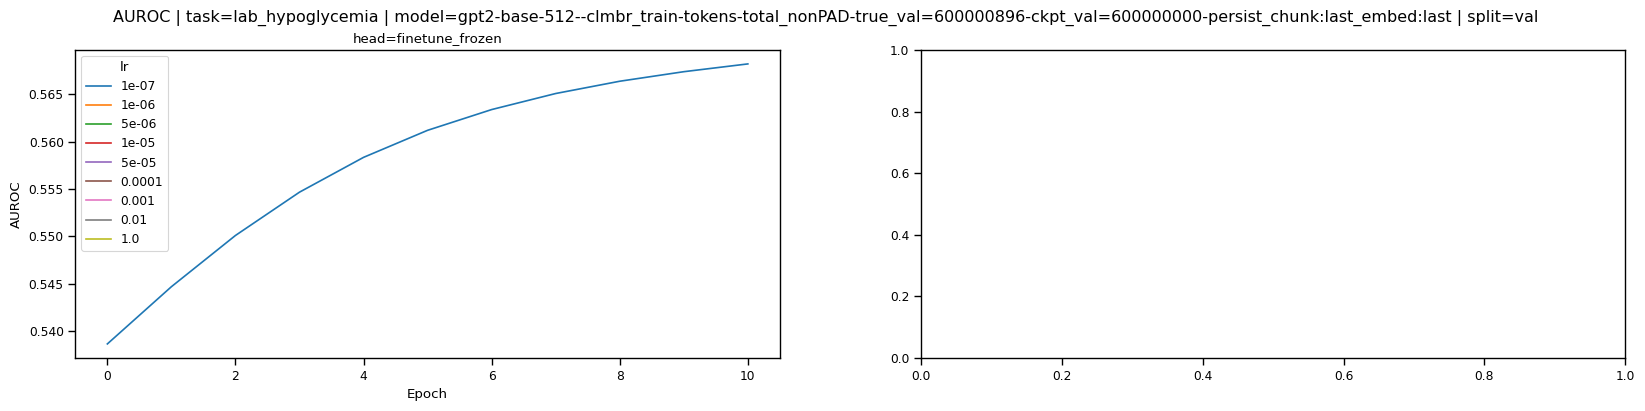

Best test AUROC for `guo_los`
                  head     value  epoch            lr
3554  finetune_frozen  0.543171     10  1.000000e-07
Best val AUROC for `guo_los`
                  head     value  epoch            lr
3553  finetune_frozen  0.568218     10  1.000000e-07


In [146]:
make_plots(df_losses, df_metrics, 'lab_hypoglycemia', model, 'val')

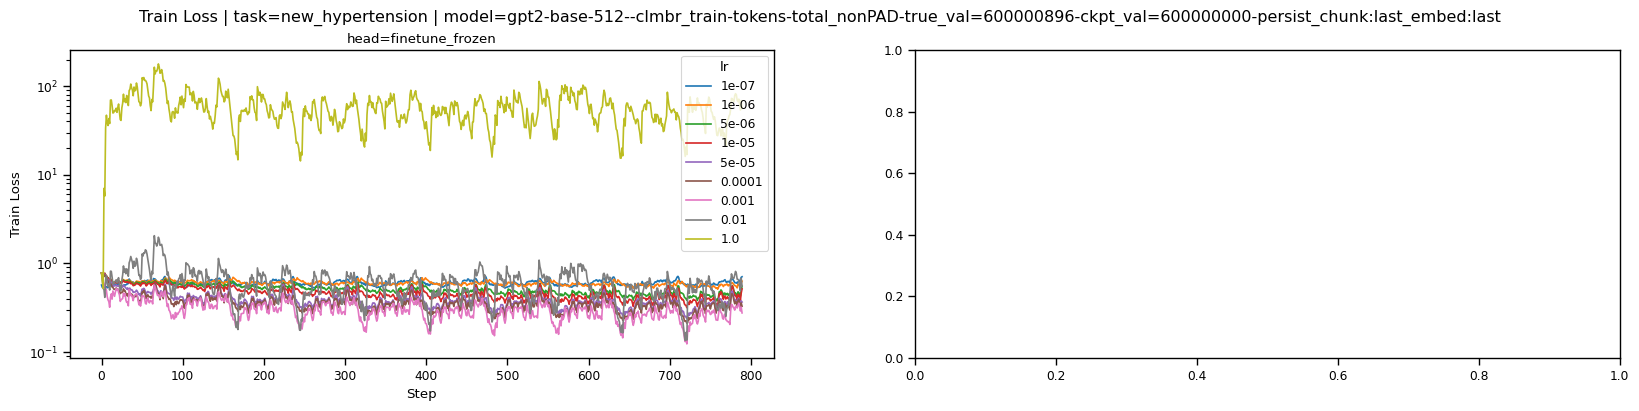

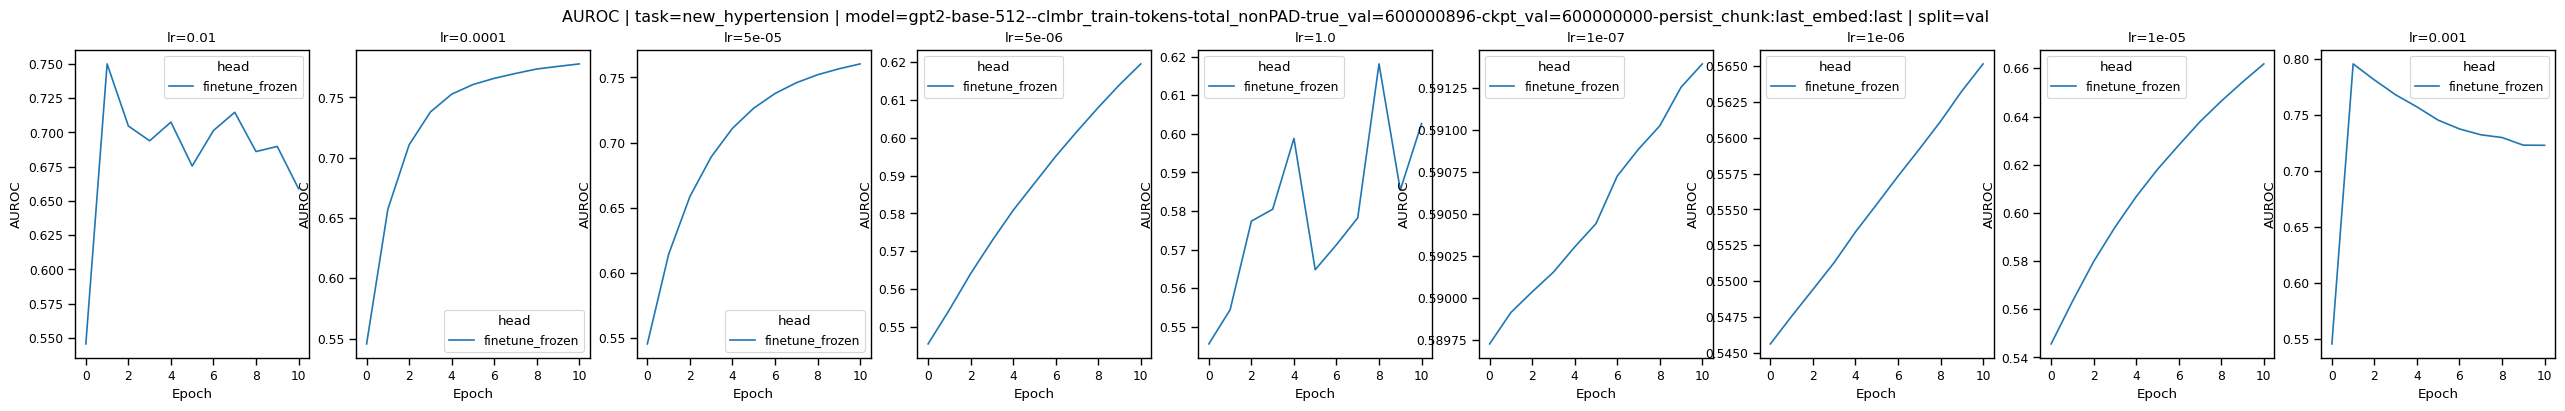

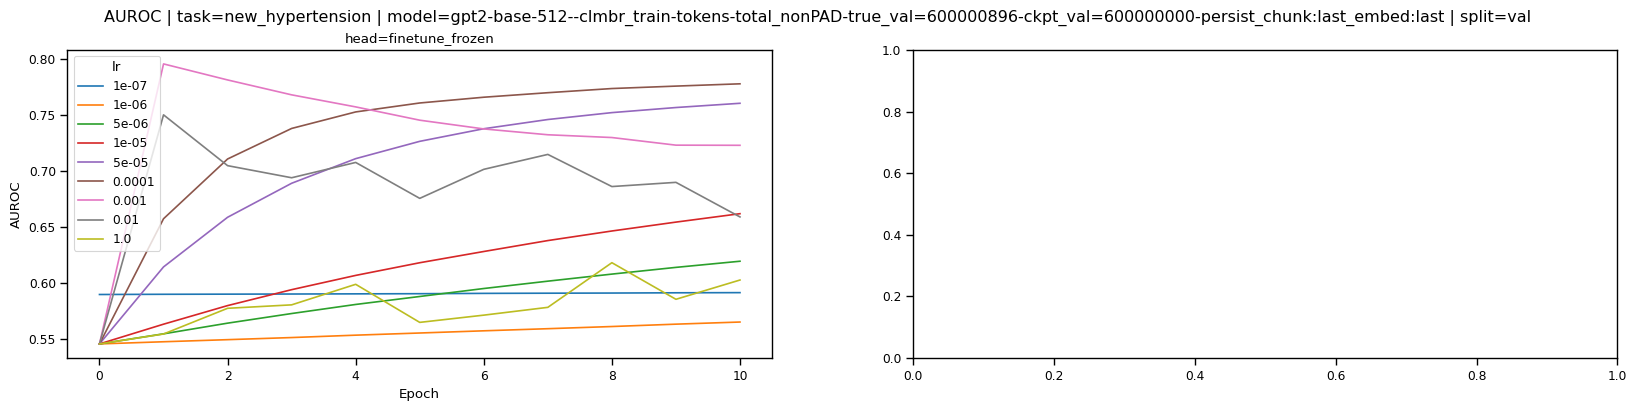

Best test AUROC for `guo_los`
                  head     value  epoch     lr
2126  finetune_frozen  0.677557      1  0.001
Best val AUROC for `guo_los`
                  head     value  epoch     lr
2125  finetune_frozen  0.795538      1  0.001


In [147]:
make_plots(df_losses, df_metrics, 'new_hypertension', model, 'val')

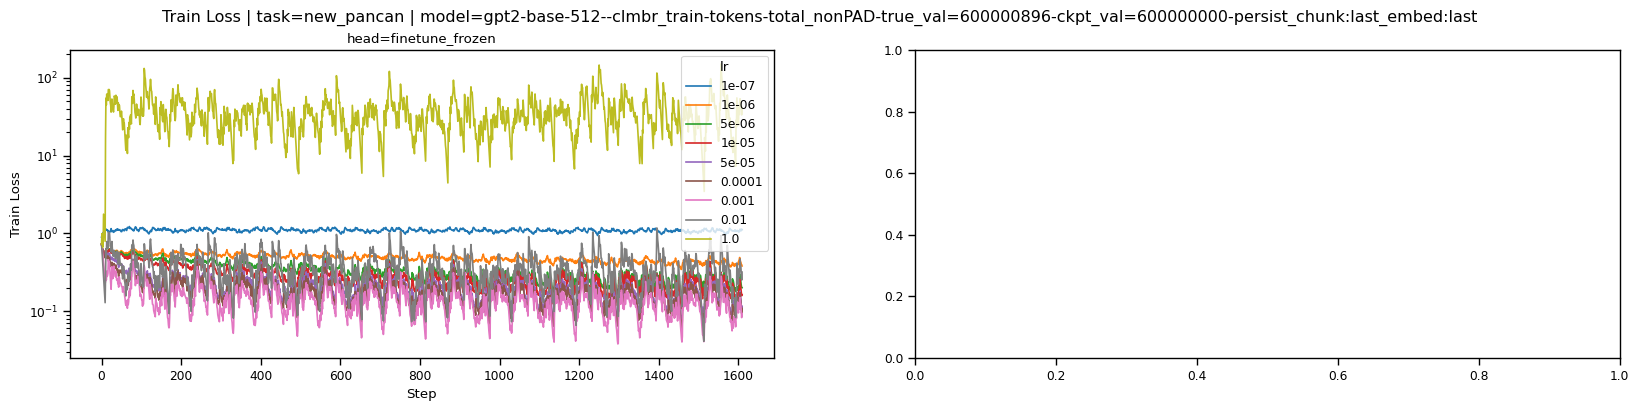

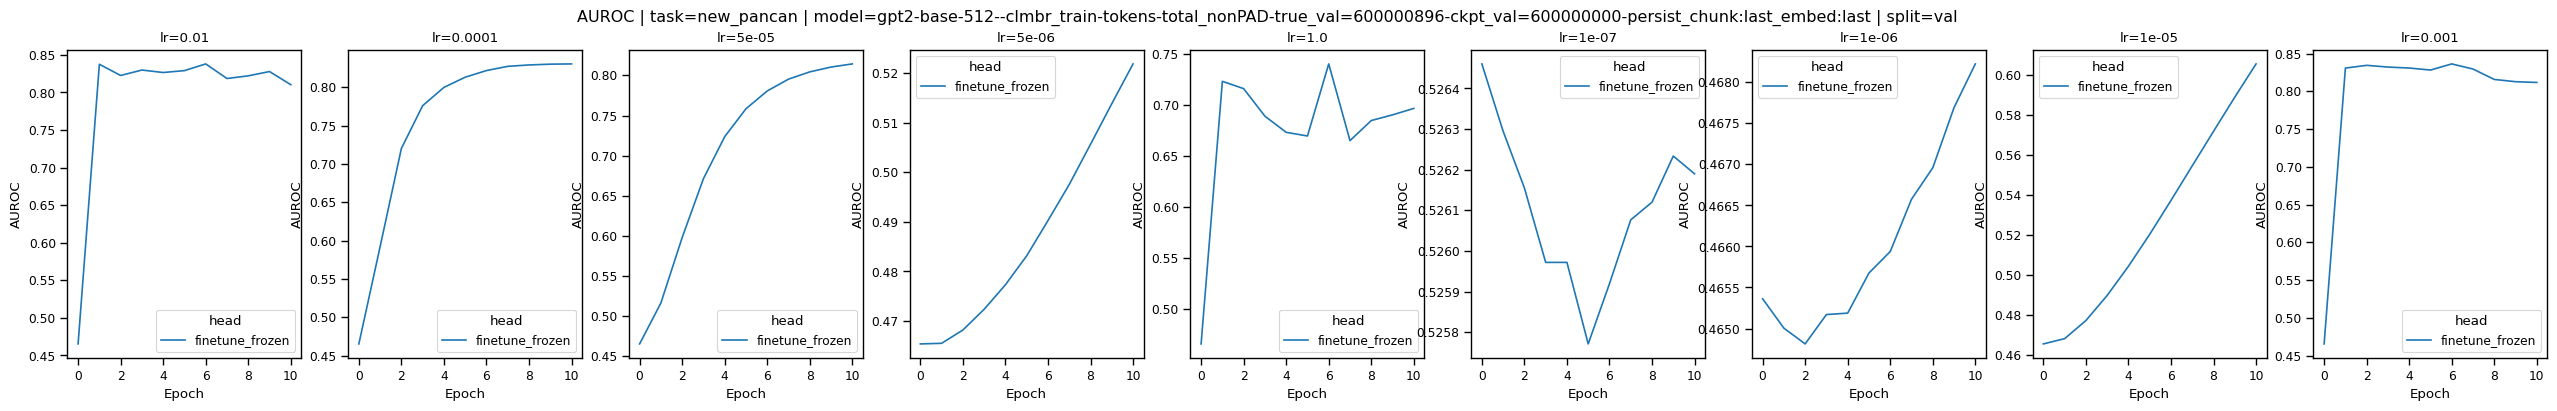

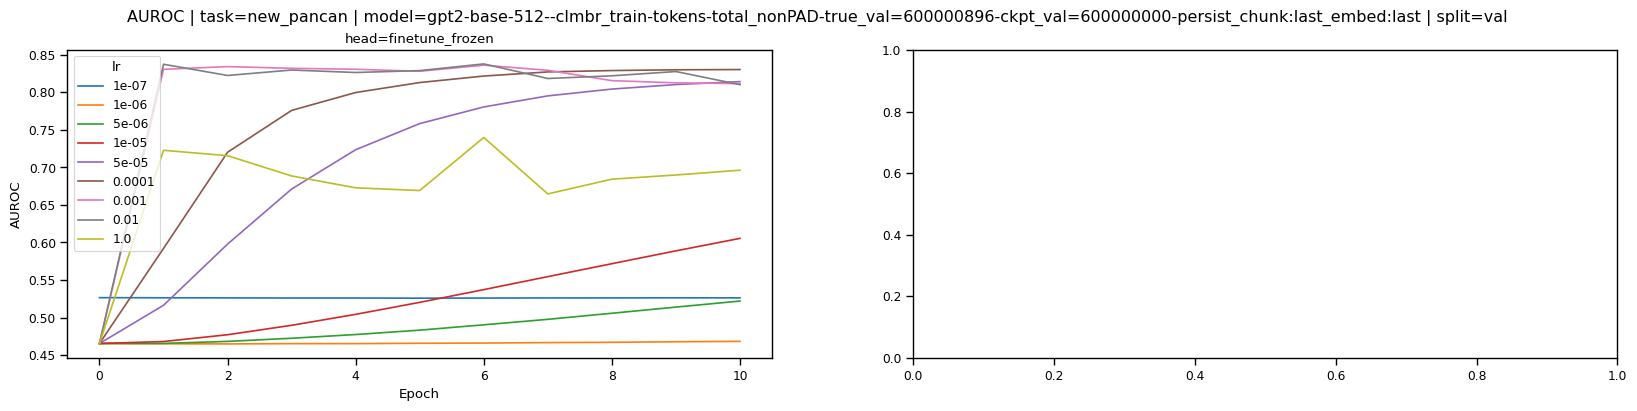

Best test AUROC for `guo_los`
                  head     value  epoch    lr
3638  finetune_frozen  0.741377      6  0.01
Best val AUROC for `guo_los`
                  head    value  epoch    lr
3637  finetune_frozen  0.83793      6  0.01


In [148]:
make_plots(df_losses, df_metrics, 'new_pancan', model, 'val')